
Bayern Munchen vs Ajax

Team0 (Ajax)
  Ground Truth: 433 (base: 433)
  Matched Prediction at Rank #2: 4231 (base: 433)
  Similarity: 0.940

Saved: E:\soccer\football_analysis\stubs\Bayern Munchen vs Ajax_v2\team0_family_matched_visualization.png


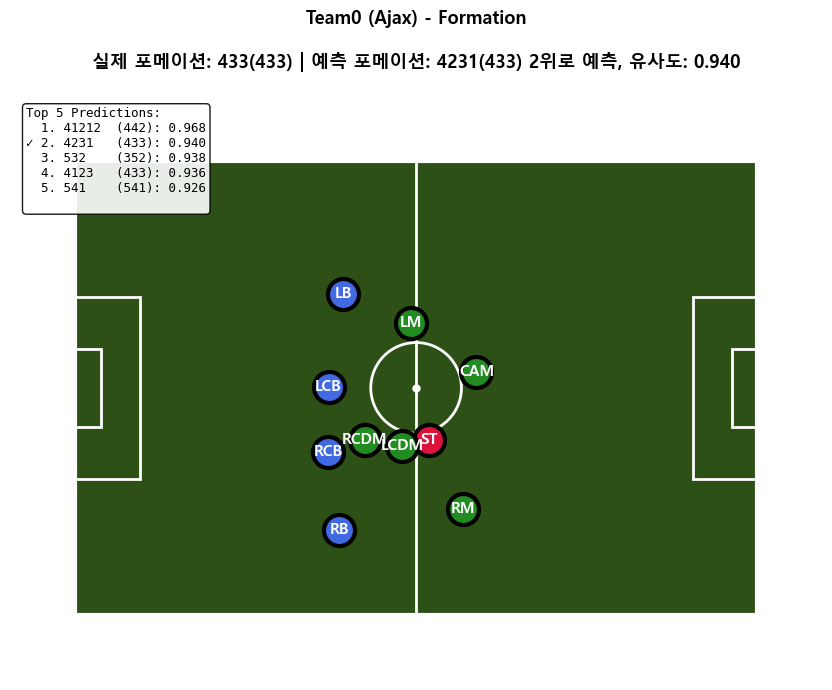


Team1 (Bayern)
  Ground Truth: 4231 (base: 433)
  Matched Prediction at Rank #2: 4213 (base: 433)
  Similarity: 0.829

Saved: E:\soccer\football_analysis\stubs\Bayern Munchen vs Ajax_v2\team1_family_matched_visualization.png


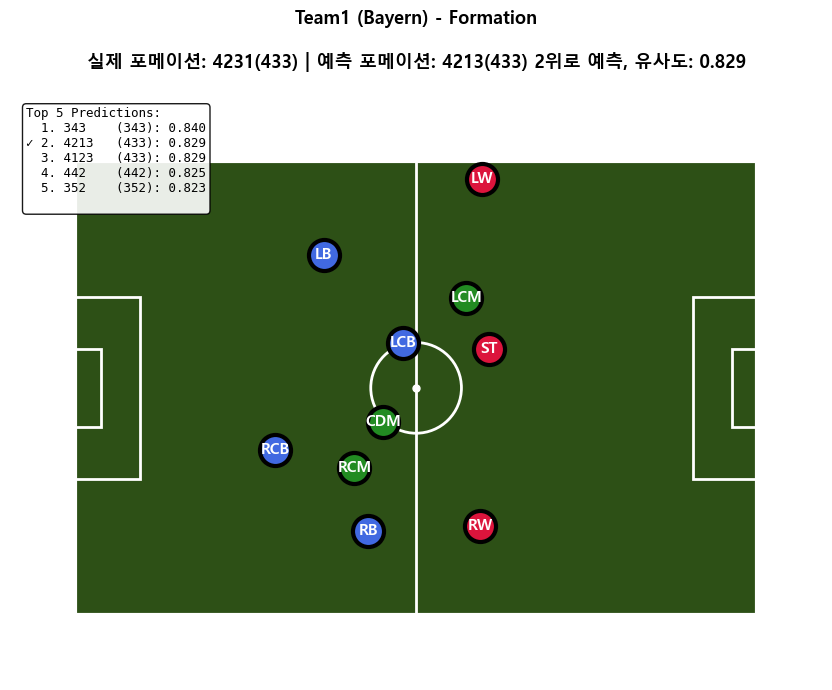

In [22]:
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc
from scipy.optimize import linear_sum_assignment
import os

plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕

# ========================================
# 1. Formation Config 로드
# ========================================
def load_formation_config(config_path=r"E:\soccer\football_analysis\formation_config.json"):
    """포메이션 설정 파일 로드"""
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)
    return config.get('formation_groups', {})

def normalize_formation_name(formation):
    """포메이션 이름 정규화"""
    if formation is None:
        return None
    return formation.replace('-', '').replace(' ', '')

def get_base_formation(formation, formation_config):
    """포메이션의 base formation 찾기"""
    normalized = normalize_formation_name(formation)
    
    for family_name, family_data in formation_config.items():
        base = family_data.get('base')
        variants = family_data.get('variants', [])
        
        # normalized가 variants에 있으면 base 반환
        if normalized in variants:
            return base
    
    # variants에 없으면 자기 자신이 base
    return normalized

def find_family_match_in_predictions(ground_truth, top_matches, formation_config):
    """
    top_matches에서 ground_truth와 같은 family에 속하는 첫 번째 포메이션 찾기
    
    Returns:
        rank, formation_name, similarity
    """
    gt_base = get_base_formation(ground_truth, formation_config)
    
    for rank, (form_name, similarity) in enumerate(top_matches, start=1):
        pred_base = get_base_formation(form_name, formation_config)
        
        if gt_base == pred_base:
            return rank, form_name, similarity
    
    # 찾지 못하면 1st 반환
    if top_matches:
        return 1, top_matches[0][0], top_matches[0][1]
    
    return None, None, None

# ========================================
# 2. 포메이션 템플릿 로드 함수
# ========================================
def load_formations():
    """포메이션 템플릿 로드"""
    import sys
    sys.path.append(r'E:\soccer\football_analysis')
    from formation_analysis.load_formation import load_formations as load_forms
    
    forms, form_names, forwards, defenders = load_forms()
    return forms, form_names

def get_formation_template(formation_name, forms, form_names):
    """특정 포메이션의 템플릿 반환"""
    normalized = normalize_formation_name(formation_name)
    
    if normalized not in form_names:
        print(f"[WARNING] Formation '{formation_name}' not found. Using '433'")
        normalized = "433"
    
    idx = form_names.index(normalized)
    return forms[idx]  # (10, 3): [x, y, role]

# ========================================
# 3. 헝가리안 매칭 함수
# ========================================
def match_players_to_formation(avg_positions, formation_template):
    """
    헝가리안 알고리즘으로 선수와 포메이션 템플릿 매칭
    """
    # 템플릿 좌표를 실제 필드 좌표로 변환
    field_width, field_height = 527.0, 351.0
    template_positions = formation_template[:, :2].astype(float)  # (10, 2)
    template_positions[:, 0] = (template_positions[:, 0] / 10.0) * field_width
    template_positions[:, 1] = (template_positions[:, 1] / 10.0) * field_height
    
    # 거리 행렬 계산
    n_players = len(avg_positions)
    cost_matrix = np.zeros((n_players, n_players))
    
    for i in range(n_players):
        for j in range(n_players):
            cost_matrix[i, j] = np.linalg.norm(avg_positions[i] - template_positions[j])
    
    # 헝가리안 알고리즘
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # 역할 할당
    roles = []
    for player_idx in range(n_players):
        template_idx = col_ind[player_idx]
        role = formation_template[template_idx, 2]
        roles.append(role)
    
    return roles

def get_position_color(role):
    """
    역할에 따라 색상 반환
    - 수비수: 파란색
    - 미드필더: 초록색  
    - 공격수: 빨간색
    """
    role = role.upper()
    
    # 수비수
    defenders = ['CB', 'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB']
    if role in defenders:
        return '#4169E1'  # Royal Blue
    
    # 공격수
    forwards = ['ST', 'LST', 'RST', 'LW', 'RW', 'CF']
    if role in forwards:
        return '#DC143C'  # Crimson Red
    
    # 미드필더 (나머지 모두)
    # CDM, CM, LCM, RCM, CAM, LM, RM 등
    return '#228B22'  # Forest Green


def filter_and_clip_positions(positions, field_width=527.0, field_height=351.0):
    """이상치 필터링 + 클리핑"""
    num_frames, num_players, _ = positions.shape
    avg_positions = np.zeros((num_players, 2))
    
    for player_idx in range(num_players):
        player_positions = positions[:, player_idx, :]
        
        # 필드 범위 내의 프레임만 선택
        valid_mask = (
            (player_positions[:, 0] >= -50) &  # 약간의 여유
            (player_positions[:, 0] <= field_width + 50) &
            (player_positions[:, 1] >= -50) & 
            (player_positions[:, 1] <= field_height + 50)
        )
        
        valid_positions = player_positions[valid_mask]
        
        if len(valid_positions) > num_frames * 0.5:  # 50% 이상 유효
            avg_positions[player_idx] = np.mean(valid_positions, axis=0)
        else:
            # 유효 데이터가 적으면 중앙값 사용
            avg_positions[player_idx] = np.median(player_positions, axis=0)
    
    # 최종 클리핑
    margin = 10
    avg_positions[:, 0] = np.clip(avg_positions[:, 0], margin, field_width - margin)
    avg_positions[:, 1] = np.clip(avg_positions[:, 1], margin, field_height - margin)
    
    return avg_positions

# ========================================
# 4. 시각화 함수
# ========================================
def visualize_ground_truth_formation(base_path, team_id, team_name):
    """
    Ground Truth 포메이션과 같은 계열의 예측을 찾아서 시각화
    """
    # 필드 크기 정의
    field_width, field_height = 527.0, 351.0
    
    # Formation Config 로드
    formation_config = load_formation_config()
    
    # 데이터 로드
    json_path = os.path.join(base_path, f"team{team_id}_overall_formation.json")
    pos_path = os.path.join(base_path, f"team{team_id}_pos.npy")
    
    with open(json_path, 'r', encoding='utf-8') as f:
        formation_data = json.load(f)
    
    positions = np.load(pos_path)  # (num_frames, 10, 2)
    avg_positions = filter_and_clip_positions(positions, field_width, field_height)    
    # Ground Truth 포메이션
    ground_truth = formation_data.get('specified_formation')
    top_matches = formation_data.get('top_matches', [])
    
    if not ground_truth:
        print(f"[ERROR] No ground truth specified for team{team_id}")
        return
    
    # 같은 family에 속하는 예측 찾기
    rank, matched_formation, similarity = find_family_match_in_predictions(
        ground_truth, top_matches, formation_config
    )
    
    if rank is None:
        print(f"[ERROR] No predictions found for team{team_id}")
        return
    
    gt_base = get_base_formation(ground_truth, formation_config)
    matched_base = get_base_formation(matched_formation, formation_config)
    
    print(f"\n{'='*60}")
    print(f"Team{team_id} ({team_name})")
    print(f"  Ground Truth: {ground_truth} (base: {gt_base})")
    print(f"  Matched Prediction at Rank #{rank}: {matched_formation} (base: {matched_base})")
    print(f"  Similarity: {similarity:.3f}")
    print(f"{'='*60}\n")
    
    # 포메이션 템플릿 로드 - matched_formation 사용!
    forms, form_names = load_formations()
    formation_template = get_formation_template(matched_formation, forms, form_names)
    
    # 헝가리안 매칭으로 역할 할당
    roles = match_players_to_formation(avg_positions, formation_template)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 필드 그리기
    ax.set_xlim(-50, field_width + 50)
    ax.set_ylim(-50, field_height + 50)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # 배경
    field_rect = Rectangle((0, 0), field_width, field_height, 
                           facecolor='#2d5016', edgecolor='white', linewidth=3)
    ax.add_patch(field_rect)
    
    # 중앙선
    ax.plot([field_width/2, field_width/2], [0, field_height], 'white', linewidth=2)
    
    # 중앙 서클
    center_circle = Circle((field_width/2, field_height/2), 35, 
                          fill=False, color='white', linewidth=2)
    ax.add_patch(center_circle)
    ax.plot(field_width/2, field_height/2, 'wo', markersize=5)
    
    # 페널티 박스
    penalty_width, penalty_height = 50, 140
    for x_start in [0, field_width - penalty_width]:
        ax.add_patch(Rectangle((x_start, (field_height - penalty_height)/2), 
                               penalty_width, penalty_height,
                               fill=False, color='white', linewidth=2))
    
    # 골 박스
    goal_width, goal_height = 20, 60
    for x_start in [0, field_width - goal_width]:
        ax.add_patch(Rectangle((x_start, (field_height - goal_height)/2), 
                               goal_width, goal_height,
                               fill=False, color='white', linewidth=2))
    
    # 선수 위치와 역할 표시
    for (x, y), role in zip(avg_positions, roles):
        # 역할에 따라 색상 결정
        color = get_position_color(role)
        
        ax.scatter(x, y, color=color, edgecolors='black', 
                  s=500, marker='o', linewidths=3, zorder=3)
        ax.text(x, y, role, fontsize=11, color='white',  # 텍스트를 흰색으로
               ha='center', va='center', weight='bold', zorder=4)
    # 타이틀
    title_text = f"Team{team_id} ({team_name}) - Formation\n\n"
    title_text += f"실제 포메이션: {ground_truth}({gt_base}) | "
    title_text += f"예측 포메이션: {matched_formation}({gt_base}) {rank}위로 예측, 유사도: {similarity:.3f}"
    
    ax.set_title(title_text, fontsize=13, weight='bold', pad=20)
    
    # Top 5 예측 표시 (family 정보 포함)
    info_text = "Top 5 Predictions:\n"
    for i, (form_name, sim) in enumerate(top_matches[:5], start=1):
        pred_base = get_base_formation(form_name, formation_config)
        
        # 현재 시각화 중인 포메이션 표시
        if i == rank:
            marker = "✓"
        # elif pred_base == gt_base:
        #     marker = "✓"  # 같은 family
        else:
            marker = " "
        
        info_text += f"{marker} {i}. {form_name:6s} ({pred_base}): {sim:.3f}\n"
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
           family='monospace')
    
 
    
    plt.tight_layout()
    
    # 저장
    save_path = os.path.join(base_path, f"team{team_id}_family_matched_visualization.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    
    plt.show()

# ========================================
# 5. 실행
# ========================================
base_path = r"E:\soccer\football_analysis\stubs\Bayern Munchen vs Ajax_v2"

# Bayern Munchen vs Ajax
print("\n" + "="*60)
print("Bayern Munchen vs Ajax")
print("="*60)

visualize_ground_truth_formation(base_path, team_id=0, team_name="Ajax")
visualize_ground_truth_formation(base_path, team_id=1, team_name="Bayern")


Team0 (FC Koln)
  Ground Truth: 4231 (base: 433)
  Matched Prediction at Rank #5: 4123 (base: 433)
  Similarity: 0.897

Saved: E:\soccer\football_analysis\stubs\FC Koln vs Hoffenheim_v2\team0_family_matched_visualization.png


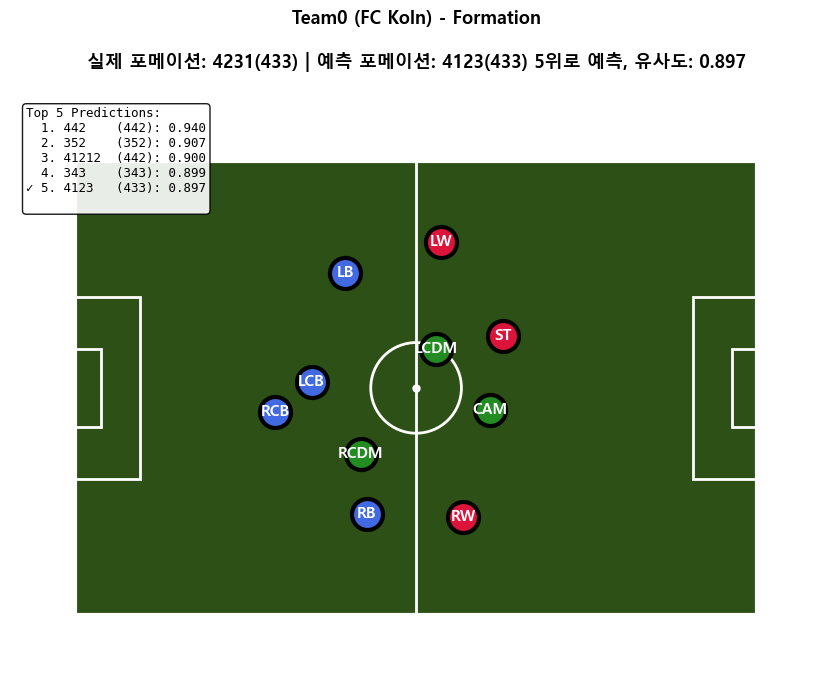


Team1 (Hoffenheim)
  Ground Truth: 352 (base: 352)
  Matched Prediction at Rank #2: 532 (base: 352)
  Similarity: 0.883

Saved: E:\soccer\football_analysis\stubs\FC Koln vs Hoffenheim_v2\team1_family_matched_visualization.png


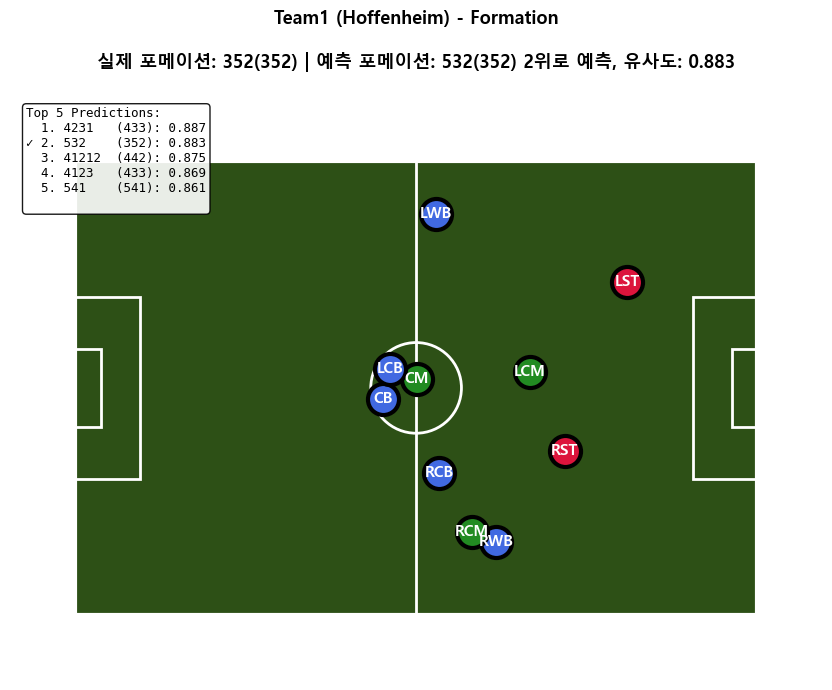

In [23]:
# 다른 경기도 똑같이
base_path = r"E:\soccer\football_analysis\stubs\FC Koln vs Hoffenheim_v2"
visualize_ground_truth_formation(base_path, 0, "FC Koln")
visualize_ground_truth_formation(base_path, 1, "Hoffenheim")


Team0 (Stuttgart)
  Ground Truth: 352 (base: 352)
  Matched Prediction at Rank #1: 352 (base: 352)
  Similarity: 0.950

Saved: E:\soccer\football_analysis\stubs\VfB Stuttgart vs Bayern Munchen_v2\team0_family_matched_visualization.png


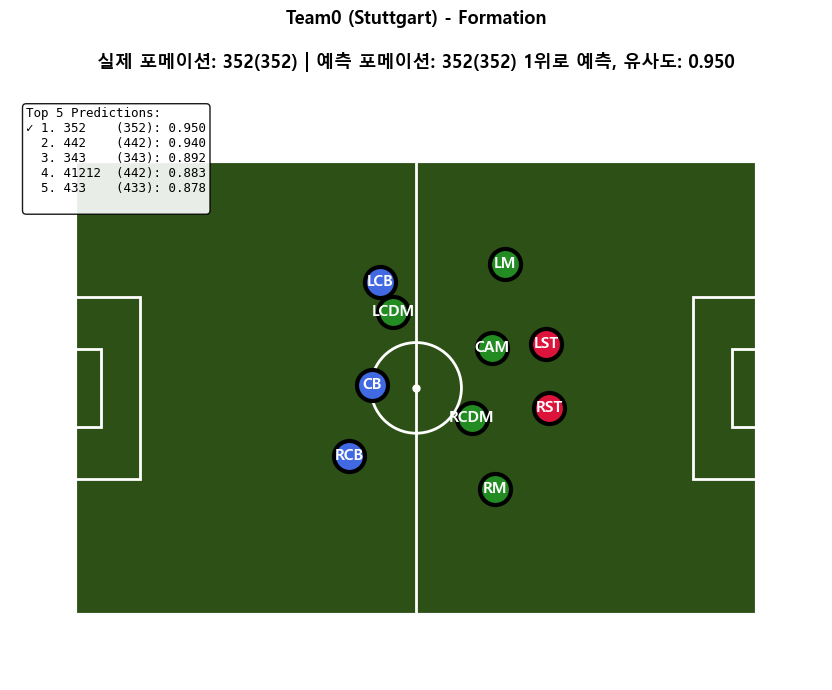


Team1 (Bayern)
  Ground Truth: 4231 (base: 433)
  Matched Prediction at Rank #5: 4123 (base: 433)
  Similarity: 0.870

Saved: E:\soccer\football_analysis\stubs\VfB Stuttgart vs Bayern Munchen_v2\team1_family_matched_visualization.png


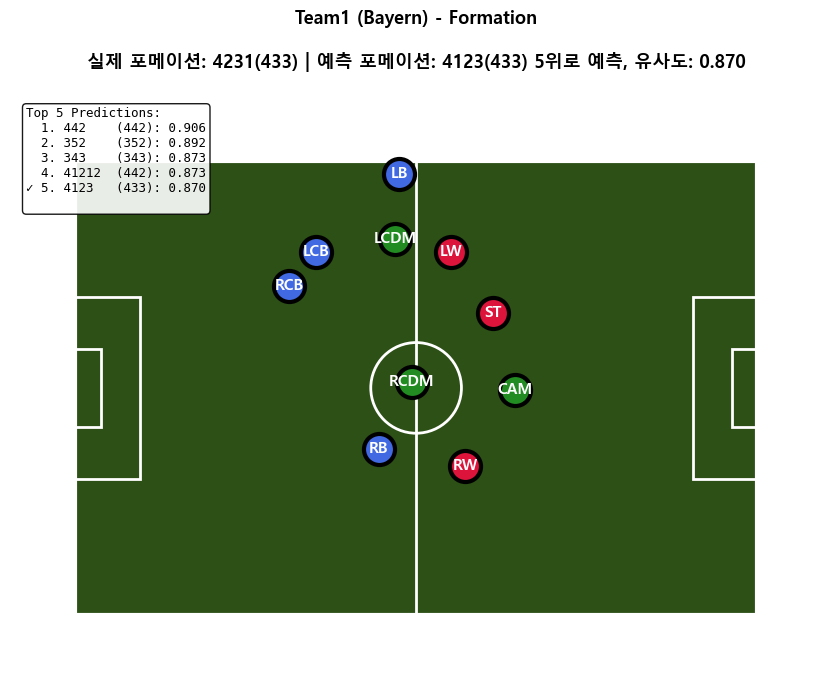

In [24]:
# 다른 경기도 똑같이
base_path = r"E:\soccer\football_analysis\stubs\VfB Stuttgart vs Bayern Munchen_v2"
visualize_ground_truth_formation(base_path, 0, "Stuttgart")
visualize_ground_truth_formation(base_path, 1, "Bayern")